# Benchmark
## A Performance Comparison to PyEMMA
In the following comparison we want to show that the performance of msmhelper is competitive to that of PyEMMA. It should be kept in mind that while both packages focus on the construction and analysis of MSM, PyEMMA has much more functionality and both packages approach Markov State modeling with a different philosophy. Nevertheless, in the following we will compare a few functions that both packages provide. We will ignore the linear algebra methods, since both packages rely on numpy.

In general, performance depends very much on the architecture and Python/package versions. Therefore, it is best to look at the benchmark results on your own device. To do this, you can simply download the Jupyter Notebook from the icon above.

In [1]:
# importing packages needed for benchmark
import msmhelper as mh
import numpy as np
import pyemma
import prettypyplot as pplt
from matplotlib import pyplot as plt

# change matplotlbiu default style
pplt.use_style(figsize=(6, 2), latex=False)


# method to visualize results
def visualize_benchmark_results(times, labels, title):
    fig, ax = plt.subplots()

    times = np.array([t.average for t in times])
    bar = ax.bar(labels, 1 / times, color=plt.colormaps['paula'].colors)
    ax.bar_label(bar,
        labels=[f'x{fac:.1f}' for fac in times[0] / times],
    )
    ax.set_ylabel(r'runs per second [1/s]')
    ax.set_ylim(np.min(1 / times) / 3, np.max(1 / times) * 3)
    ax.set_yscale('log')
    
    # highlight relative performance
    ax.set_title(title)


def generate_traj(n_steps, n_states):
    """Generate random state trajectory."""
    return np.random.randint(low=1, high=n_states + 1, size=n_steps)

## Estimation of a Markov State Model

In [2]:
# create random trajectory
n_steps = int(1e5)
n_states = 10
lagtime = 100

Using numba the source code gets compiled just-in-time on the first usage. Hence, we need to run the code once in advance to measure the performance without compilation time. For further informations see the [numba docs](https://numba.readthedocs.io/en/stable/user/5minguide.html#how-to-measure-the-performance-of-numba).

In [3]:
traj = generate_traj(n_steps, n_states),
tmp = mh.msm.estimate_markov_model(traj, lagtime=lagtime)
tmp = mh.msm.implied_timescales(traj, [lagtime], ntimescales=2)
tmp = mh.msm.ck_test(traj, [lagtime], tmax=1000)
tmp = mh.msm.timescales.propagate_MCMC(traj, lagtime, 100)

/home/dn1016/Documents/Github/msmhelper/src/msmhelper/msm/timescales.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  impl_timescales[idx] = _implied_timescales(


In the following, we compare the determination of the Markov State Model from a numpy state trajectory.

In [4]:
%%timeit -r 10 -n 1 -q -o traj = generate_traj(n_steps, n_states)
msm = mh.msm.estimate_markov_model(traj, lagtime=lagtime)

<TimeitResult : 2.38 ms ± 203 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [5]:
time_msm_mh_traj = _

In [6]:
%%timeit -r 10 -n 1 -q -o traj = generate_traj(n_steps, n_states)
pyemma.msm.estimate_markov_model(traj, lag=lagtime, reversible=False)

<TimeitResult : 6.88 ms ± 736 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [7]:
time_msm_pyemma_nonrev = _

In [8]:
%%timeit -r 10 -n 1 -q -o traj = generate_traj(n_steps, n_states)
pyemma.msm.estimate_markov_model(traj, lag=lagtime)

<TimeitResult : 7.21 ms ± 1.18 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [9]:
time_msm_pyemma_rev = _

If you have already formatted the trajectory, msmhelper is even significantly faster:

In [10]:
%%timeit -r 10 -n 1 -q -o traj = mh.StateTraj(generate_traj(n_steps, n_states))
traj.estimate_markov_model(lagtime=lagtime)

<TimeitResult : 226 µs ± 46.4 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [11]:
time_msm_mh_statetraj = _

Comparing the perforamance we find

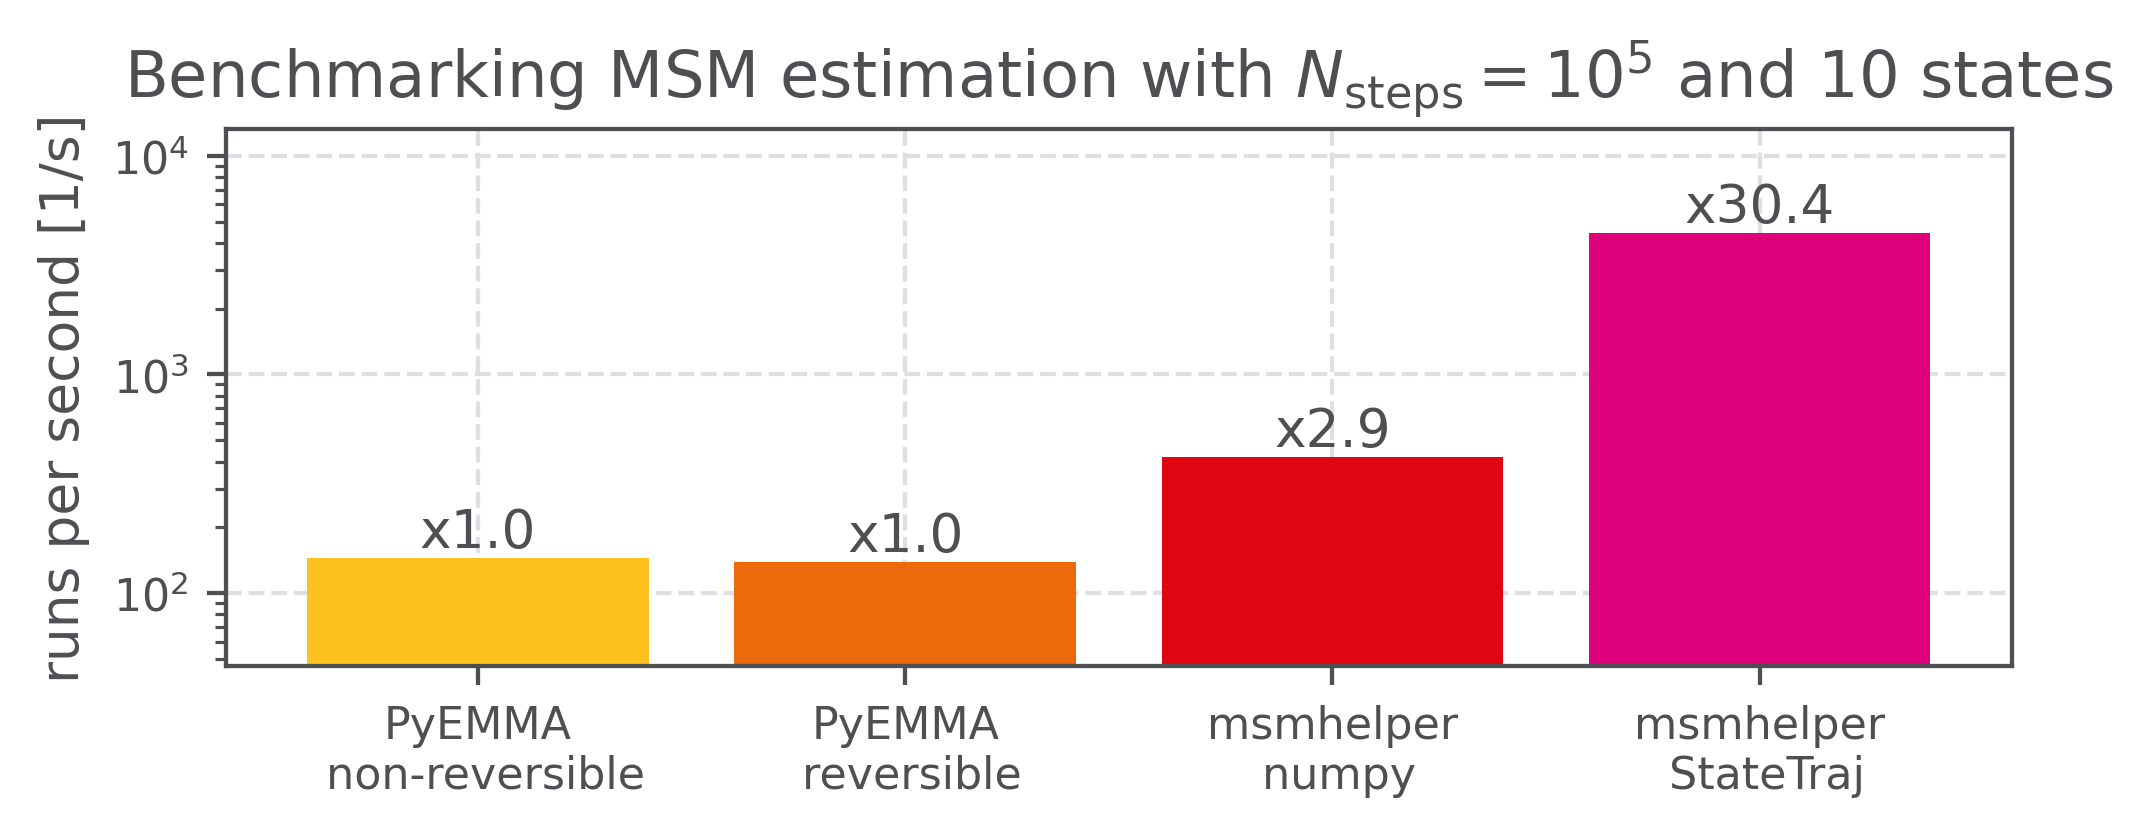

In [12]:
visualize_benchmark_results(
    (time_msm_pyemma_nonrev, time_msm_pyemma_rev, time_msm_mh_traj, time_msm_mh_statetraj),
    ('PyEMMA\n non-reversible', 'PyEMMA\n reversible', 'msmhelper\n numpy', 'msmhelper\n StateTraj'),
    f'Benchmarking MSM estimation with $N_\mathrm{{steps}}=10^{np.log10(n_steps):.0f}$ and {n_states} states',
)

Increasing the number of states and steps we find:

In [13]:
# create random trajectory with more states and frames
n_steps = int(1e7)
n_states = 100

In [14]:
%%timeit -r 5 -n 1 -q -o traj = mh.StateTraj(generate_traj(n_steps, n_states))
traj.estimate_markov_model(lagtime=lagtime)

<TimeitResult : 16.6 ms ± 519 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [15]:
time_msm_mh_statetraj = _

In [16]:
%%timeit -r 5 -n 1 -q -o traj = generate_traj(n_steps, n_states)
mh.msm.estimate_markov_model(traj, lagtime=lagtime)

<TimeitResult : 372 ms ± 8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [17]:
time_msm_mh_traj = _

In [18]:
%%timeit -r 5 -n 1 -q -o traj = generate_traj(n_steps, n_states)
pyemma.msm.estimate_markov_model(traj, lag=lagtime, reversible=False)

<TimeitResult : 794 ms ± 162 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [19]:
time_msm_pyemma_nonrev = _

In [20]:
%%timeit -r 5 -n 1 -q -o traj = generate_traj(n_steps, n_states)
pyemma.msm.estimate_markov_model(traj, lag=lagtime, reversible=True)

<TimeitResult : 683 ms ± 24.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [21]:
time_msm_pyemma_rev = _

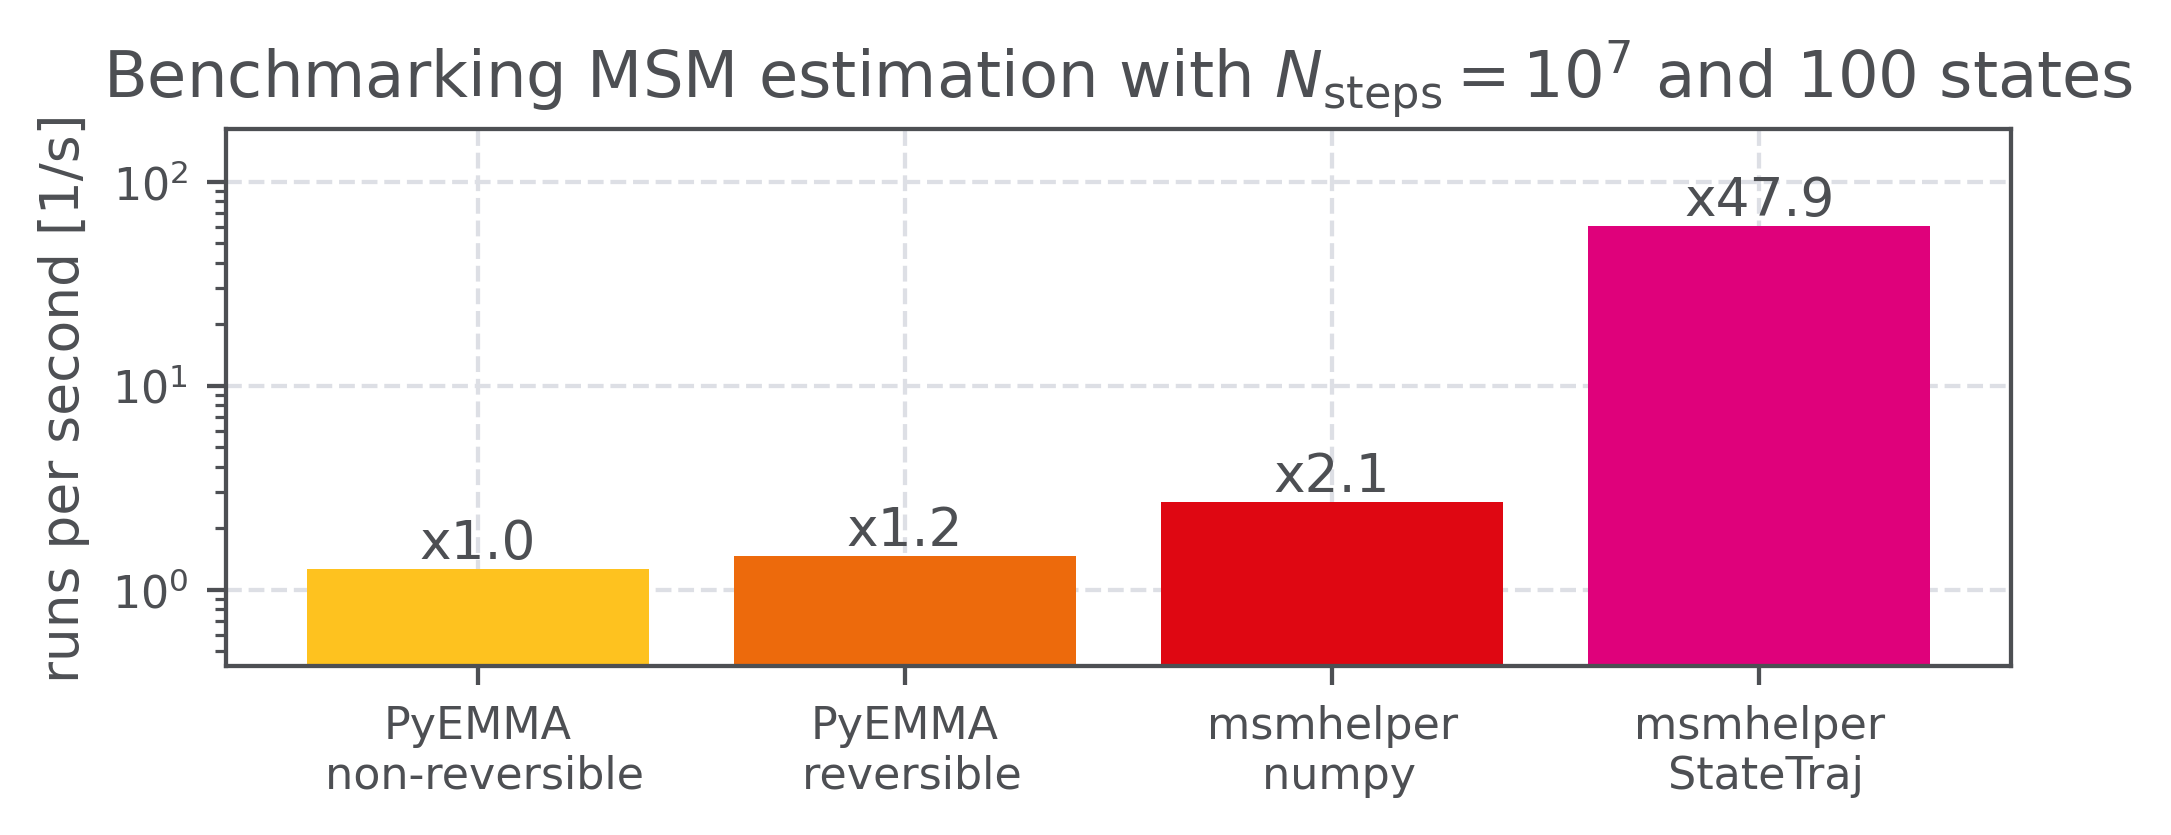

In [22]:
visualize_benchmark_results(
    (time_msm_pyemma_nonrev, time_msm_pyemma_rev, time_msm_mh_traj, time_msm_mh_statetraj),
    ('PyEMMA\n non-reversible', 'PyEMMA\n reversible', 'msmhelper\n numpy', 'msmhelper\n StateTraj'),
    f'Benchmarking MSM estimation with $N_\mathrm{{steps}}=10^{np.log10(n_steps):.0f}$ and {n_states} states',
)

## Estimation of Implied Timescales

An important property of Markov State models are the implied time scales. These correspond to the $i$-th eigenvalue $\lambda_i$ of the transition matrix $T_{ij}$
and are defined by
$$t_i = - \frac{t_\text{lag}}{\log(\lambda_i)}$$

In [23]:
# create random trajectory
n_steps = int(1e5)
n_states = 10
n_timescales = 2

# creating lagtimes
lagtimes = np.unique(np.geomspace(1, 100, 20).astype(int))
print(f'lagtimes: {", ".join(lagtimes.astype(str))}')

# catch warnings, because random state trajectory has mainly complex eigenvalues
import warnings

lagtimes: 1, 2, 3, 4, 5, 6, 8, 11, 14, 18, 23, 29, 37, 48, 61, 78, 100


In [24]:
%%timeit -r 5 -n 1 -q -o traj = generate_traj(n_steps, n_states)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mh.msm.implied_timescales(traj, lagtimes, ntimescales=n_timescales)

<TimeitResult : 9.03 ms ± 721 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [25]:
time_impl_mh = _

In [26]:
%%timeit -r 5 -n 1 -q -o traj = generate_traj(n_steps, n_states)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pyemma.msm.its(
        traj,
        lagtimes,
        nits=n_timescales,
        show_progress=False,
        reversible=False,
        n_jobs=1,  # keeping this to None it does not work with PyEMMA 2.5.12
    ).timescales

<TimeitResult : 144 ms ± 9.35 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [27]:
time_impl_pyemma = _

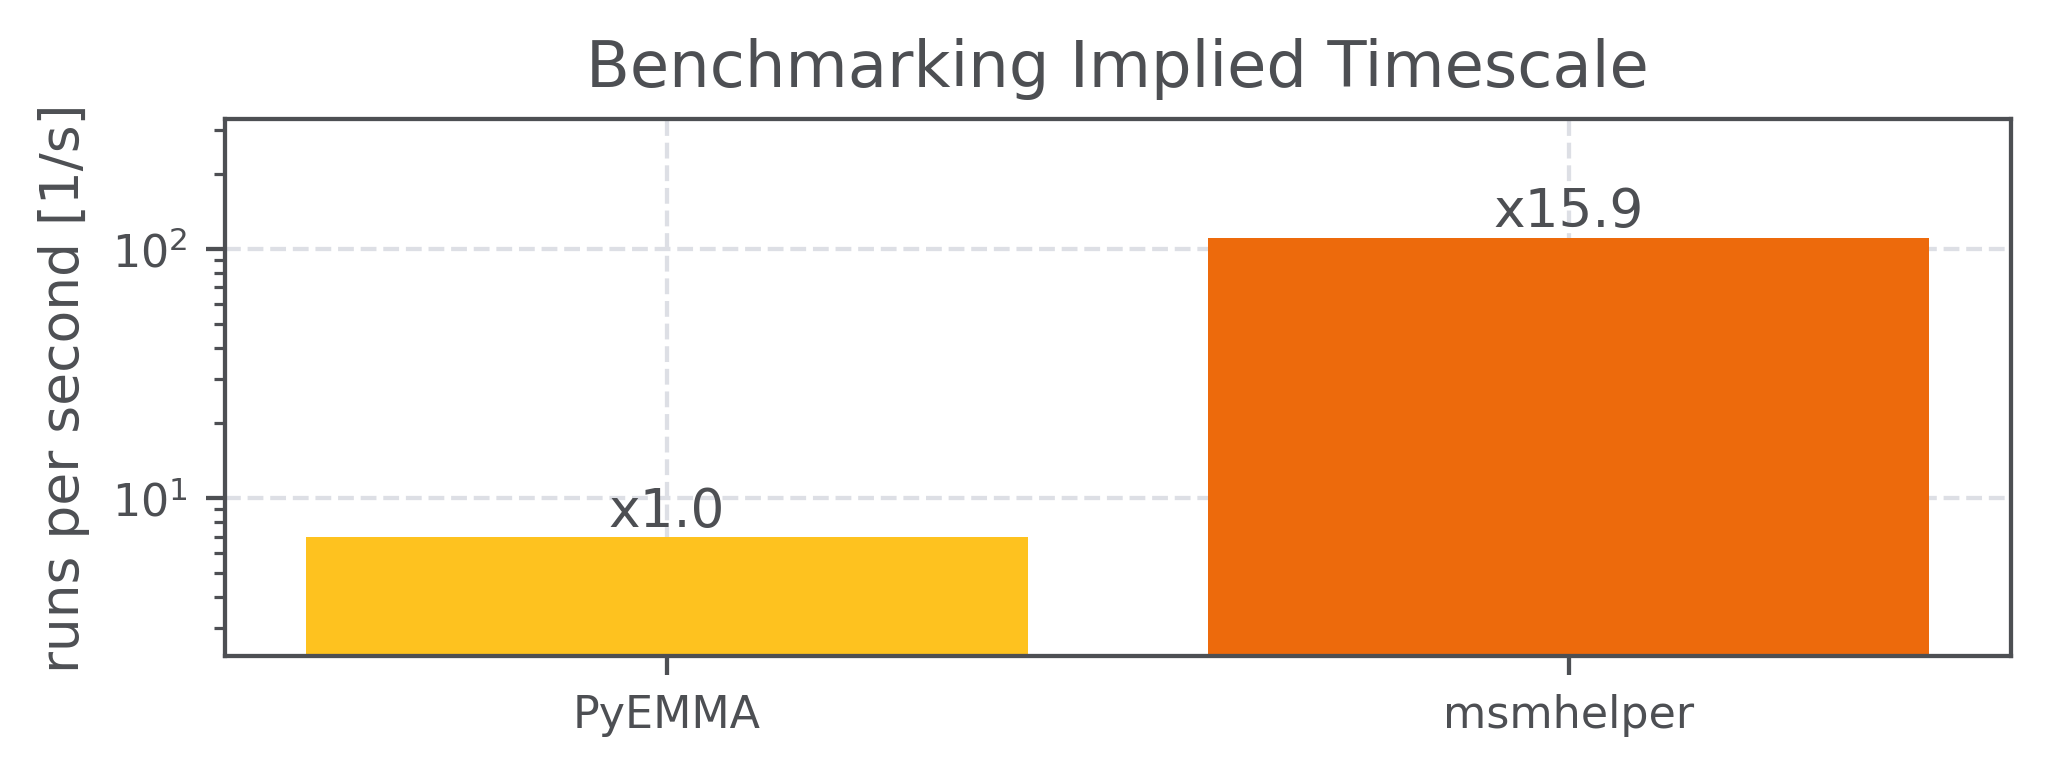

In [28]:
visualize_benchmark_results(
    (time_impl_pyemma, time_impl_mh),
    ('PyEMMA', 'msmhelper'),
    f'Benchmarking Implied Timescale',
)

## Chapman-Kolmogorov Test
The most important test to check the Markovianity of a MSM is the Chapman-Kolmogorov test which visualizes the agreement of the Chapman-Kolomogorov equation
$$T(\tau n) = T^n(\tau)$$
The following comparison is not easy to interpret, because both packages do not determine the same thing. However, it should be sufficient to get a feeling.

In [29]:
%%timeit -r 5 -n 1 -q -o traj = generate_traj(n_steps, n_states)
mh.msm.ck_test(traj, lagtimes, tmax=1000)

<TimeitResult : 38.2 ms ± 3.09 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [30]:
time_cktest_mh = _

In [31]:
%%timeit -r 5 -n 1 -q -o traj = generate_traj(n_steps, n_states)
for lagtime in lagtimes:
    msm = pyemma.msm.estimate_markov_model(traj, lag=lagtime)
    msm.cktest(2, n_jobs=1, show_progress=False)

<TimeitResult : 1.63 s ± 36.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [32]:
time_cktest_pyemma = _

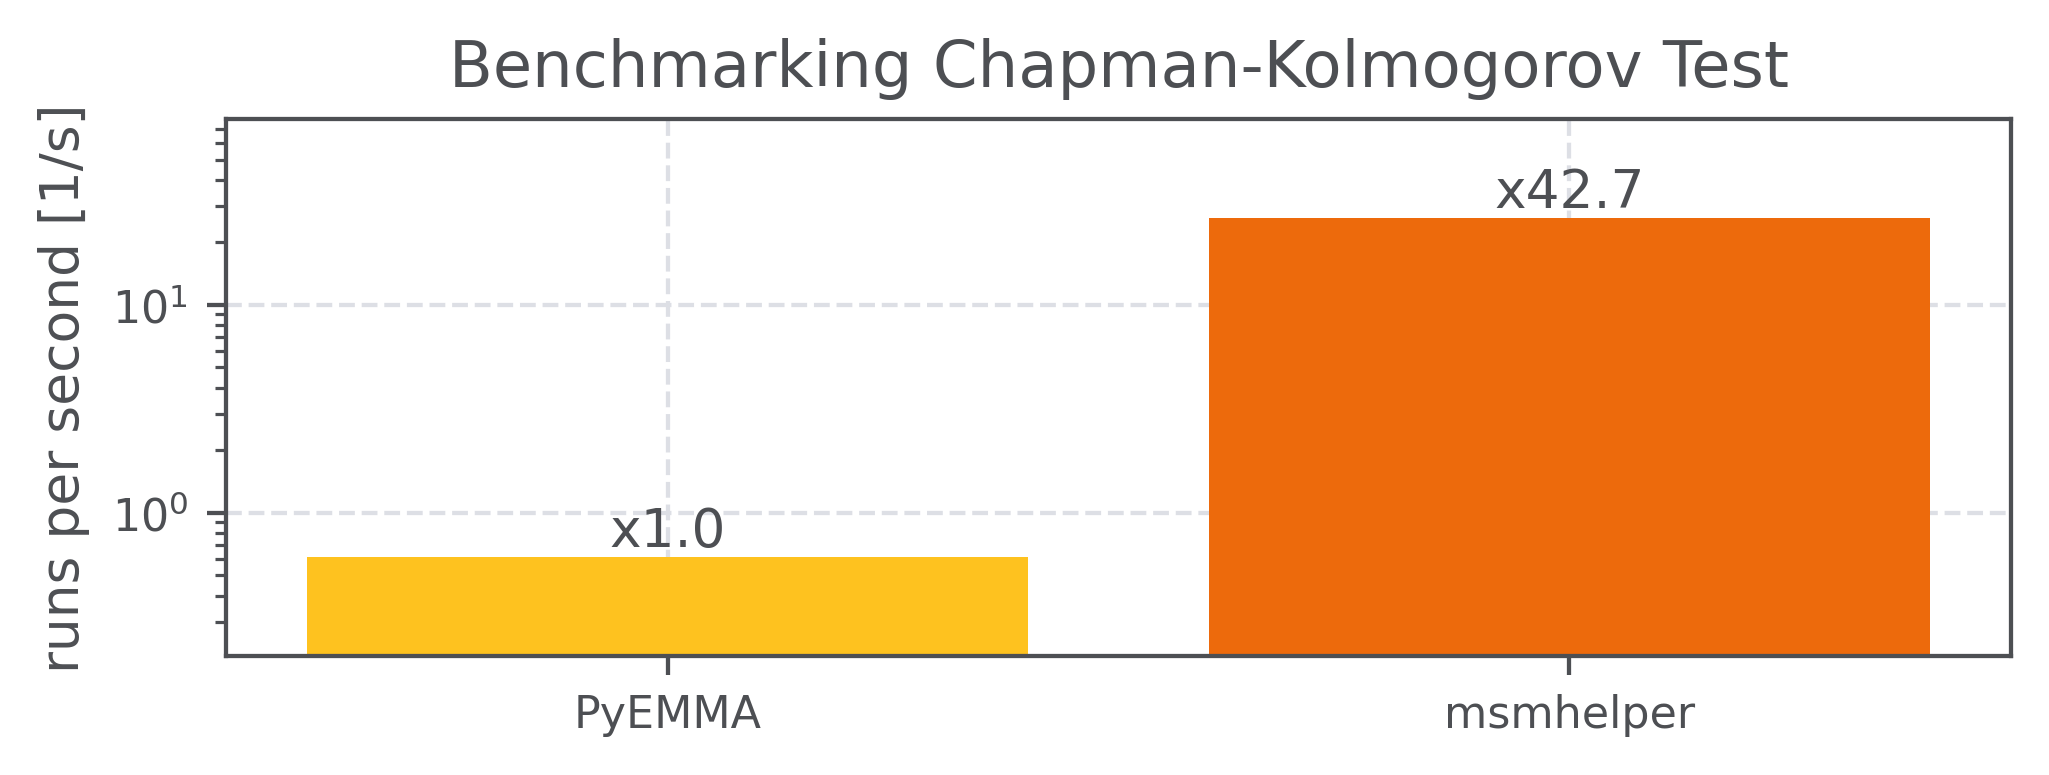

In [33]:
visualize_benchmark_results(
    (time_cktest_pyemma, time_cktest_mh),
    ('PyEMMA', 'msmhelper'),
    f'Benchmarking Chapman-Kolmogorov Test',
)

## Propagating a Markov Chain Monte Carlo
We now consider the propagation of a Markov chain Monte Carlo, since this plays a central role in the package msmhelper to estimate the time scales.

In [34]:
# decrease number of steps to speed up msm estimation
n_steps = int(1e4)
n_states = 10

# number to propagate MCMC
n_mcmc_steps = int(1e6)

In [35]:
%%timeit -r 5 -n 1 -q -o traj = mh.StateTraj(generate_traj(n_steps, n_states))
mcmc = mh.msm.timescales.propagate_MCMC(traj, lagtime, n_mcmc_steps)

<TimeitResult : 39.9 ms ± 1.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [36]:
time_mcmc_mh = _

In [37]:
%%timeit -r 5 -n 1 -q -o msm = pyemma.msm.estimate_markov_model(generate_traj(n_steps, n_states), lag=lagtime)
msm.generate_traj(n_mcmc_steps)

<TimeitResult : 2.83 s ± 38.7 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [38]:
time_mcmc_pyemma = _

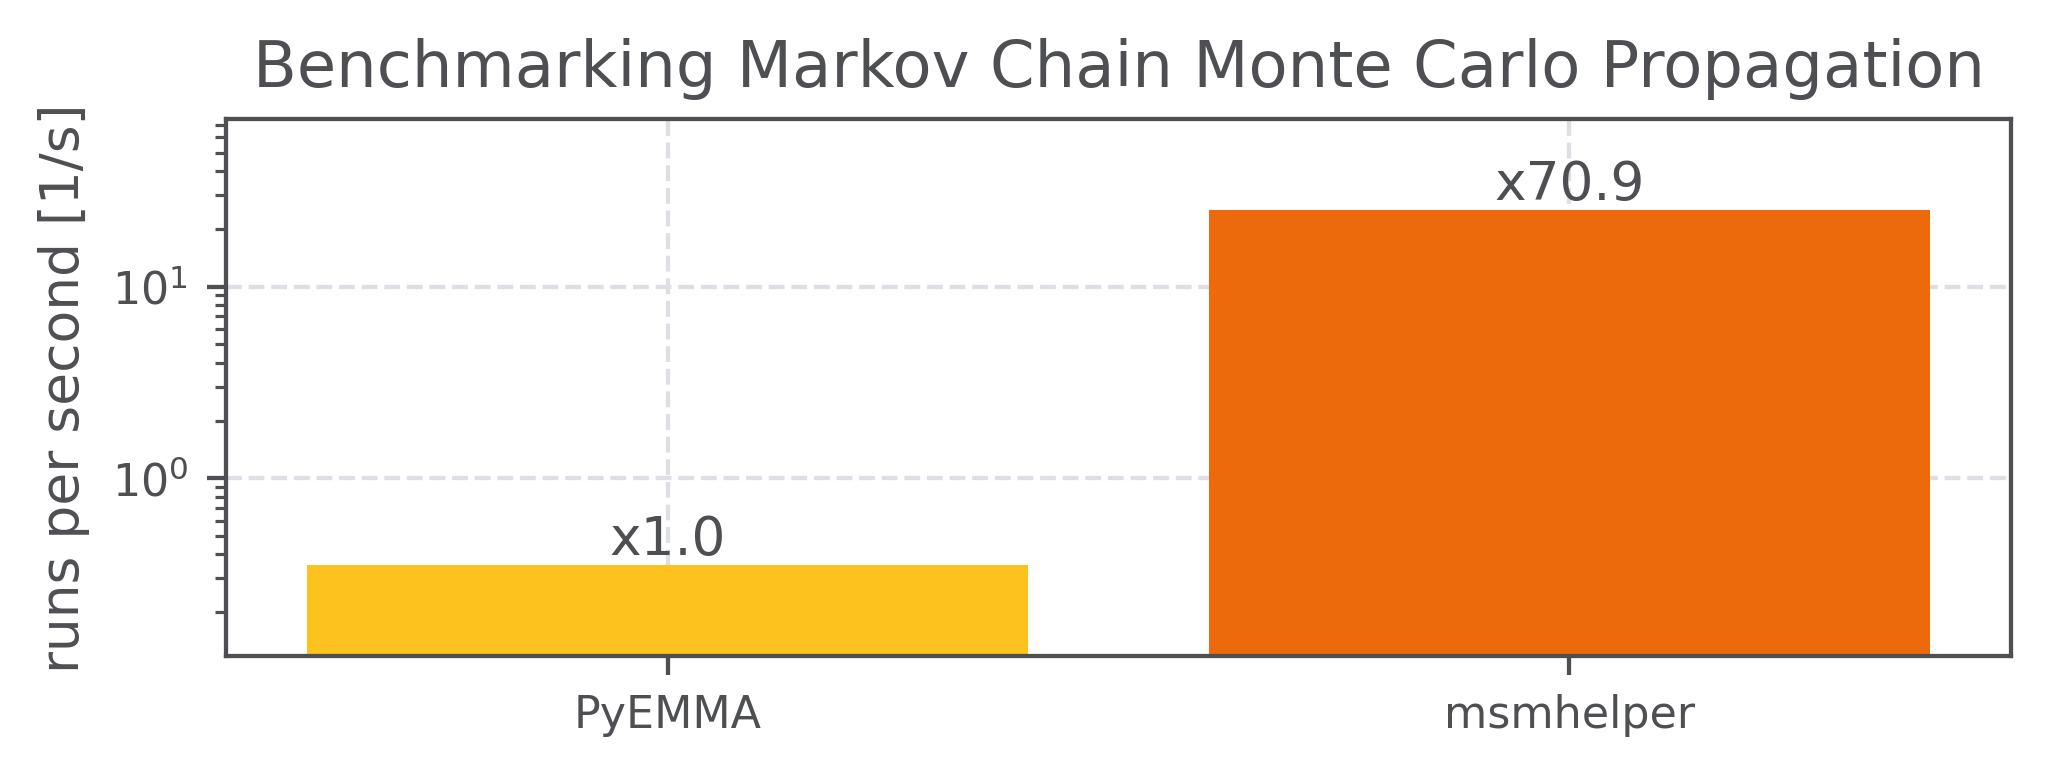

In [39]:
visualize_benchmark_results(
    (time_mcmc_pyemma, time_mcmc_mh),
    ('PyEMMA', 'msmhelper'),
    f'Benchmarking Markov Chain Monte Carlo Propagation',
)